# Making a Grid of NYC
Data taken from [NYC Open Data - Borough Boundaries](https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm)

In [1]:
import geopandas as gpd

In [2]:
nyc_geojson = './data/Borough Boundaries.geojson'
nyc_bounds = gpd.read_file(nyc_geojson)

In [3]:
nyc_bounds

,boro_code,boro_name,shape_area,shape_leng,geometry
0,5,Staten Island,1623620725.06,325917.353702,"MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ..."
1,2,Bronx,1187182350.92,463176.004334,"MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ..."
2,3,Brooklyn,1934229471.99,728263.543413,"MULTIPOLYGON (((-73.86327 40.58388, -73.86381 ..."
3,1,Manhattan,636520830.696,357564.317228,"MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ..."
4,4,Queens,3041418543.49,888199.780587,"MULTIPOLYGON (((-73.82645 40.59053, -73.82642 ..."


## Creating Longitude and Latitude Grid
Each cell in the grid will be 0.001 degrees longitude (x-coordinate) by 0.001 degrees latitude (y-coordinate), roughly 111m x 111m.

In [4]:
import shapely

In [5]:
# NYC min-max longitude, latitude (x, y) coordinates in thousandths
# Ex. Longitude: -74.50 = -74500
MIN_X = -74258
MAX_X = -73700
MIN_Y = 40496
MAX_Y = 40916

STEP = 0.001

In [6]:
grid = []
for x in range(MIN_X, MAX_X):
    for y in range(MIN_Y, MAX_Y):
        cell = {'geometry': shapely.box(xmin=x*STEP, xmax=(x + 1)*STEP, ymin=y*STEP, ymax=(y + 1)*STEP)}
        grid.append(cell)

print('Number of cells in grid:', len(grid))

Number of cells in grid: 234360


In [7]:
grid_df = gpd.GeoDataFrame(grid, crs='EPSG:4326')
grid_df.head(3)

,geometry
0,"POLYGON ((-74.25700 40.49600, -74.25700 40.497..."
1,"POLYGON ((-74.25700 40.49700, -74.25700 40.498..."
2,"POLYGON ((-74.25700 40.49800, -74.25700 40.499..."


In [8]:
grid_df.iloc[0]['geometry'].bounds

(-74.258, 40.496, -74.257, 40.497)

## Create Grid of NYC
Excluding cells completely encompassing water.

In [9]:
import numpy as np

In [10]:
# Create single object to determine intersections
bounds = shapely.geometrycollections(list(nyc_bounds['geometry']))

# Create column where grid cell intersects NYC boundaries
grid_df['in_nyc'] = np.where(grid_df['geometry'].intersects(bounds), True, False)

# Filter grid
grid_df = grid_df.loc[grid_df['in_nyc'] == True]

print('Number of cells in grid:', len(grid))

Number of cells in grid: 234360


Plot of NYC based on GeoJson

<AxesSubplot: >

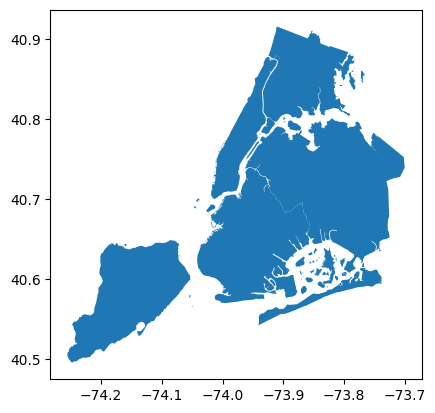

In [11]:
nyc_bounds.plot()

Plot of ~111m by 111m Cell Grid of NYC, a little grainier

<AxesSubplot: >

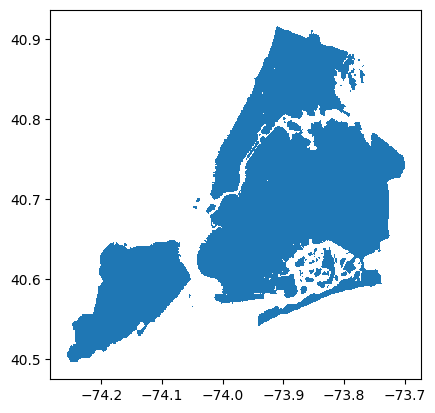

In [12]:
grid_df.plot()

## Cell Coordinates
We will be using the southeastern coordinate as the cell identifier as this makes it easier bin coordinates by truncating coordinates instead of running `shapely` or `geopandas` intersects.  Example: `Point(-74.1642 40.5433)` is in the cell `Polygon(-74.165 40.543, -74.164 40.544)`.

In [13]:
import json

In [22]:
# Check where eastern and southern bounds are in tuple
grid_df.iloc[0]['geometry'].bounds

(-74.256, 40.503, -74.255, 40.504)

In [28]:
data = {
    'data': list(grid_df['geometry'].apply(
        lambda x: {'latitude': round(x.bounds[1], 3), 'longitude': round(x.bounds[2], 3)}
    ))
}

In [31]:
filename = './data/nyc-grid.json'
with open(filename,'w') as f:
    obj = json.dumps(data, indent=2)
    f.write(obj)